In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#### 1. Скачать данные о рынке недвижимости c открытого соревнования Сбербанка по машинному обучению https://www.kaggle.com/c/sberbank-russian-housing-market/data. Скачиваем только файлы train.csv.zip, macro.csv.zip и сливаем в один датафрейм. Описание колонок - data_dictionary.txt

In [2]:
train_set = pd.read_csv('train.csv')
macro_set = pd.read_csv('macro.csv')

In [3]:
train_set.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [4]:
macro_set.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [5]:
train_set.shape

(30471, 292)

In [6]:
macro_set.shape

(2484, 100)

In [7]:
x = train_set.merge(macro_set, on = 'timestamp', how = 'left')
x_raw = x.copy()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
x.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [8]:
x.shape

(30471, 391)

### 2-6. Провести чистку данных (пропуски данных, неинформативные признаки, аномалии, оцифровка текстовых столбцов и т.п.)
### Провести Exploratory Data Analysis. Проанализировать переменные, влияющие на зависимую переменную - стоимость недвижимости price_doc.
### Разделить датасет на обучающие и тестовую выборки.
### Обучить регрессионную модель предсказывать стоимость недвижимости в зависимости от разных факторов и выявить показатели качества модели на обучающей и тестовой выборке.
### Реализовать методы feature engineering с целью повышения метрик качества модели. 

In [9]:
#рассмотрим нашу переменную

In [10]:
x['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

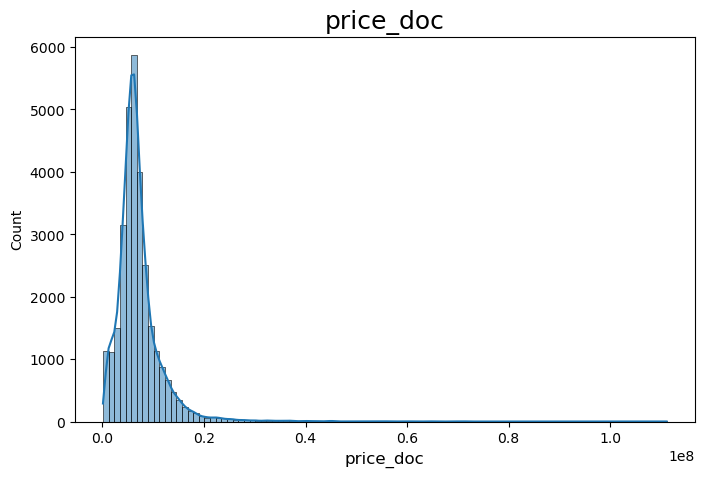

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(x['price_doc'].values, bins=100, kde=True, ax=ax)
plt.title('price_doc', fontsize=18)
plt.xlabel('price_doc', fontsize=12)
plt.show()

In [12]:
# на диаграмме видно. ненормальное распределение значений, 
# поэтому прологарифмируем переменую для более удобного восприятия

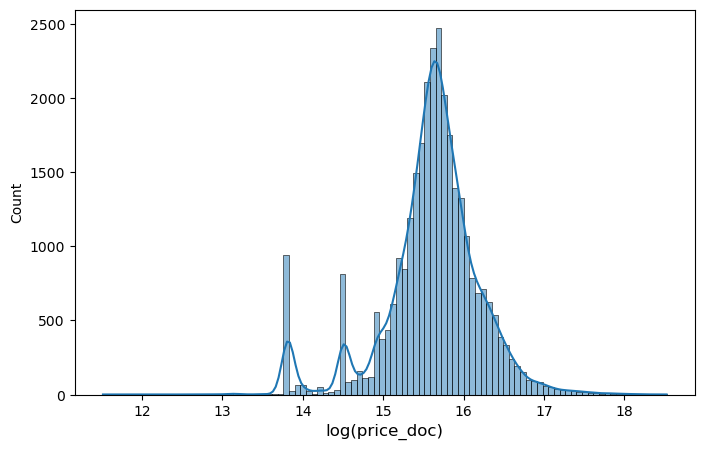

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(np.log(x['price_doc']).values, bins=100, kde=True, ax=ax)
plt.xlabel('log(price_doc)', fontsize=12)
plt.show()

In [14]:
# добавим значения в таблицу

In [15]:
x['price_doc_log'] = np.log(x['price_doc'])

In [16]:
x.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [17]:
# заменим '#!' по столбцу 'child_on_acc_pre_school' на NaN 

In [18]:
x['child_on_acc_pre_school'] = x['child_on_acc_pre_school'].replace('#!', np.nan)

In [19]:
# рассмотрим корреляцию нашего признака с остальными

In [20]:
corrs = x.corr(method='pearson')
corr_with_prices = corrs["price_doc"][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]].head(50)

price_doc                         1.000000
num_room                          0.476337
full_sq                           0.341840
sport_count_5000                  0.294864
sport_count_3000                  0.290651
trc_count_5000                    0.289371
zd_vokzaly_avto_km               -0.284069
sadovoe_km                       -0.283622
kremlin_km                       -0.279249
apartment_fund_sqm                0.036461
bulvar_ring_km                   -0.279158
sport_count_2000                  0.278056
ttk_km                           -0.272620
office_sqm_5000                   0.269977
trc_sqm_5000                      0.268072
sport_count_1500                  0.258376
nuclear_reactor_km               -0.257946
sport_objects_raion               0.252794
trc_count_3000                    0.242068
cafe_count_5000_price_1000        0.240464
stadium_km                       -0.236924
cafe_count_5000_price_1500        0.232612
cafe_count_5000                   0.231546
cafe_count_

In [21]:
# Из расчетов видно, какие признаки наиболее влияют на целевую переменную. 
# Помимо площади, количества комнат, большое влияние оказывает доступность спортивных, культурных и социальных 
# объектов в округе,транспортного сообщения

In [22]:
corr_with_prices[abs(corr_with_prices).argsort()[::-1]].tail(165)

grp                                           0.101001
provision_doctors                            -0.100585
micex_cbi_tr                                  0.100352
mosque_count_2000                             0.100228
build_count_before_1920                       0.099973
leisure_count_1000                            0.099571
cafe_sum_2000_min_price_avg                   0.098951
rent_price_3room_bus                          0.098862
gas_share                                    -0.096402
mosque_count_3000                             0.096199
power_clinics                                -0.094921
cafe_count_500_price_500                      0.094835
bandwidth_sports                              0.121824
green_zone_part                              -0.094486
max_floor                                     0.094386
railroad_km                                  -0.094227
oil_urals                                    -0.094128
trc_sqm_1500                                  0.093110
cafe_count

In [23]:
# Из расчетов видно, что 161 признак имеет корреляют с целевым менее 0,1. Исключим их

In [24]:
toDelete = list(corr_with_prices[abs(corr_with_prices).argsort()[::-1]].tail(161).index)
print(toDelete[0], toDelete[-1])

build_count_before_1920 trc_sqm_500


In [25]:
print(x.shape, '\n')

for col in toDelete:
    x.drop(col, axis=1, inplace=True)

print(x.shape, '\n')

(30471, 392) 

(30471, 231) 



In [26]:
# Проверим датасет на пропуски данных

In [27]:
missingValues = x.columns[x.isnull().any()].tolist()
pd.isnull(x[missingValues]).sum().sort_values(ascending=False)

provision_retail_space_modern_sqm    29718
museum_visitis_per_100_cap           16901
hospital_beds_raion                  14441
state                                13559
num_room                              9572
life_sq                               6383
old_education_build_share             5592
modern_education_share                5592
build_count_monolith                  4991
build_count_brick                     4991
cafe_sum_1500_min_price_avg           4199
cafe_sum_1500_max_price_avg           4199
cafe_avg_price_1500                   4199
child_on_acc_pre_school               3992
construction_value                    3239
hospital_bed_occupancy_per_year       3239
hospital_beds_available_per_cap       3239
provision_doctors                     3239
incidence_population                  3239
unprofitable_enterpr_share            3239
fin_res_per_cap                       3239
profitable_enterpr_share              3239
grp                                   3239
cafe_sum_20

In [28]:
# Заменим пропуски средним значением и модой
# Сотавим списки

In [29]:
fillna_mode = ['floor',                
 'num_room',
 'state',
 'hospital_beds_raion',
 'build_count_brick',
 'modern_education_share',
 'old_education_build_share',
 'unprofitable_enterpr_share',
 'build_count_monolith',
 'hospital_bed_occupancy_per_year',
 'hospital_beds_available_per_cap',
 'provision_doctors',
 'child_on_acc_pre_school',
 'incidence_population',
 'fin_res_per_cap',
 'profitable_enterpr_share',
 'museum_visitis_per_100_cap']

fillna_mean = ['life_sq',
 'construction_value',
 'provision_retail_space_modern_sqm',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_max_price_avg',
 'grp',
 'cafe_avg_price_2000',
 'metro_min_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'metro_km_walk']

In [30]:
for col in fillna_mode:
    x[col].fillna(x[col].mode().iloc[0],inplace=True)

for col in fillna_mean:
    x[col].fillna(x[col].mean(),inplace=True)

In [31]:
print(x.isnull().sum().sum())

0


In [32]:
# Проверим датасет на NaN

In [33]:
isMissing = x.isna()
isMissing.sum().sum()

0

In [34]:
x.head()

,id,timestamp,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,mosque_count_2000,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,cpi,ppi,gdp_deflator,usdrub,eurrub,gdp_annual,gdp_annual_growth,rts,micex_rgbi_tr,micex_cbi_tr,deposits_value,grp,salary,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,labor_force,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,fin_res_per_cap,construction_value,average_life_exp,incidence_population,child_on_acc_pre_school,load_of_teachers_school_per_teacher,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,hospital_beds_available_per_cap,h

In [35]:
# Отформатируем даты, добавим новые данные (год и месяц) и посмотрим динамику изменения цен по месяцам и по годам

In [36]:
x['year'] = x['timestamp'].apply(lambda x: x[:4]).astype(int)
x['month'] = x['timestamp'].apply(lambda x: x[5:7]).astype(int)

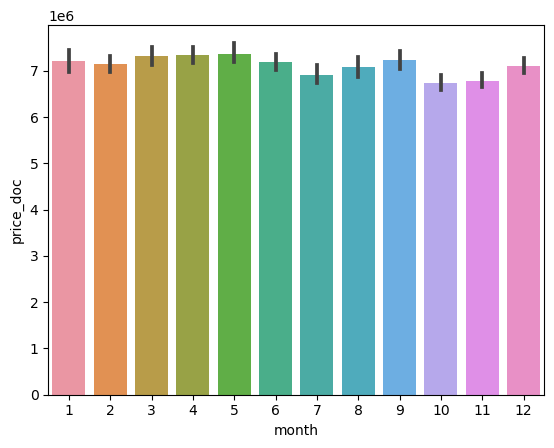

In [37]:
sns.barplot(x='month', y='price_doc', data=x)
plt.show()

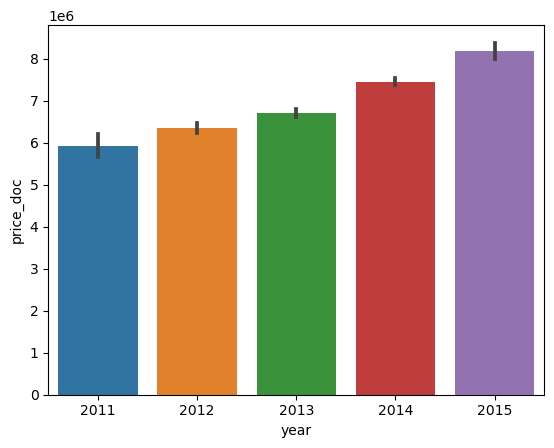

In [38]:
sns.barplot(x='year', y='price_doc', data=x)
plt.show()

In [39]:
# Посмотрим изменение цен в зависимости от района

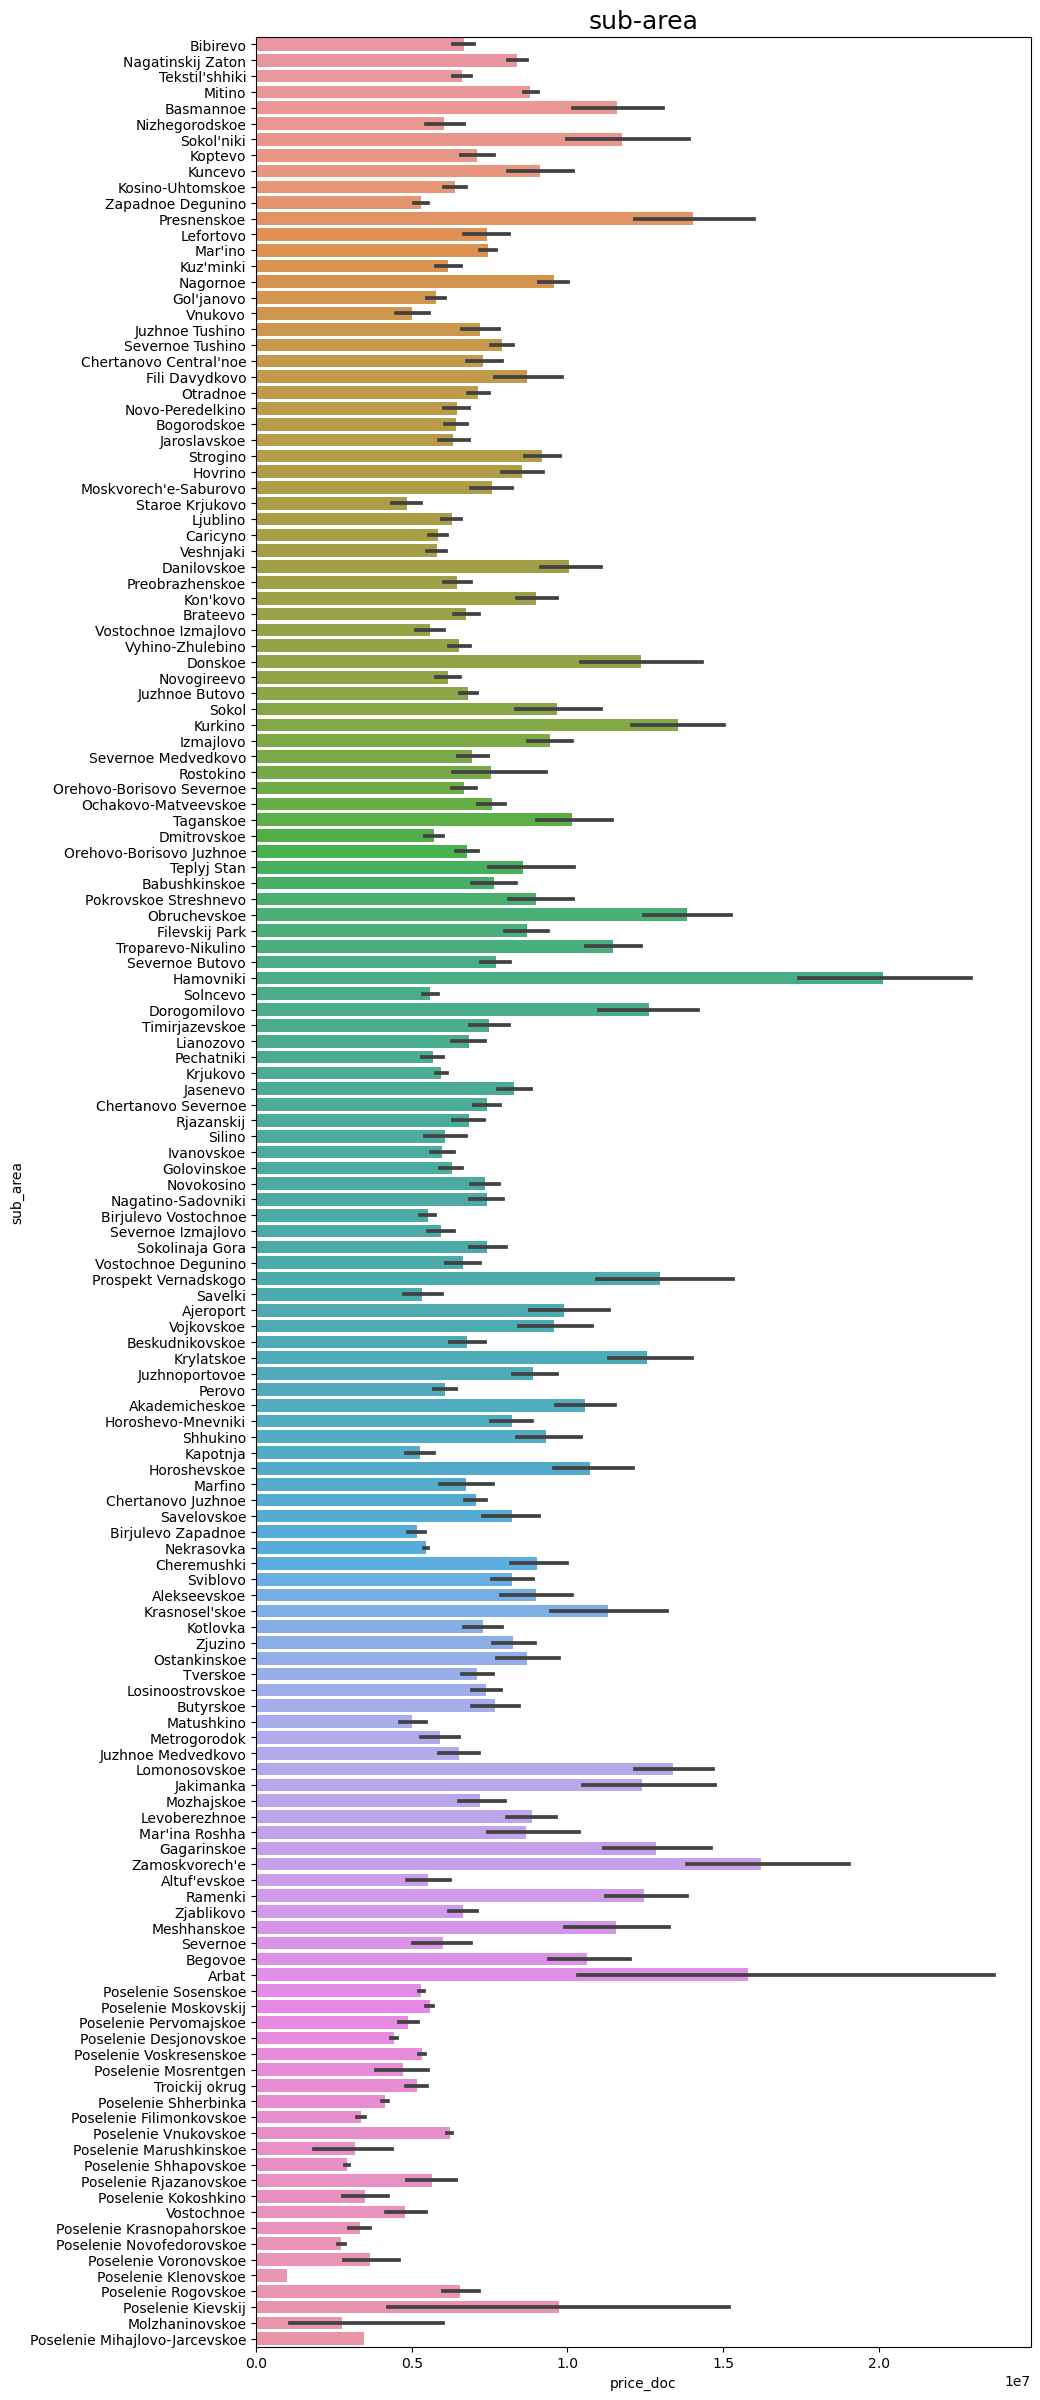

In [40]:
fig, ax = plt.subplots(figsize=(10,30))
sns.barplot(y='sub_area', x='price_doc', data=x, orient='h')
plt.title('sub-area', fontsize=18)
plt.show()

In [41]:
# Наиболее дорогая недвижимость в Хамовниках, Замоскворечьи, на Арбате

In [42]:
# Посмотрим изменение средних цен в зависимости от этажа

<AxesSubplot:xlabel='floor', ylabel='price_doc'>

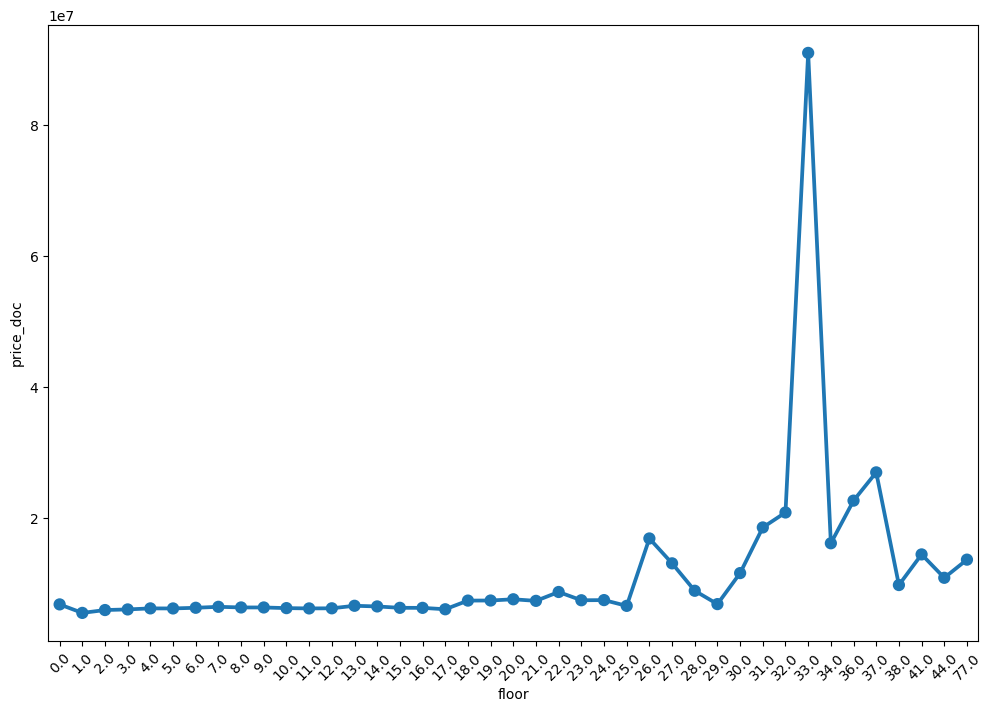

In [43]:
plt.figure(figsize=(12, 8))
plt.xticks(rotation=45)
df = x.groupby(by=['floor'])['price_doc'].aggregate(np.median).reset_index()
sns.pointplot(x='floor', y='price_doc', data=df)

In [44]:
# На графике видно, что значение переменной принимает аномальное значение на 33 этаже. Удалим его

In [45]:
x[(x['floor']) == 33]

,id,timestamp,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,mosque_count_2000,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,cpi,ppi,gdp_deflator,usdrub,eurrub,gdp_annual,gdp_annual_growth,rts,micex_rgbi_tr,micex_cbi_tr,deposits_value,grp,salary,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,labor_force,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,fin_res_per_cap,construction_value,average_life_exp,incidence_population,child_on_acc_pre_school,load_of_teachers_school_per_teacher,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,hospital_beds_available_per_cap,h

In [46]:
x.drop(x.index[7457], inplace=True)

In [47]:
# Посмотрим изменение средних цен в зависимости от количества жилых комнат

<AxesSubplot:xlabel='num_room', ylabel='price_doc'>

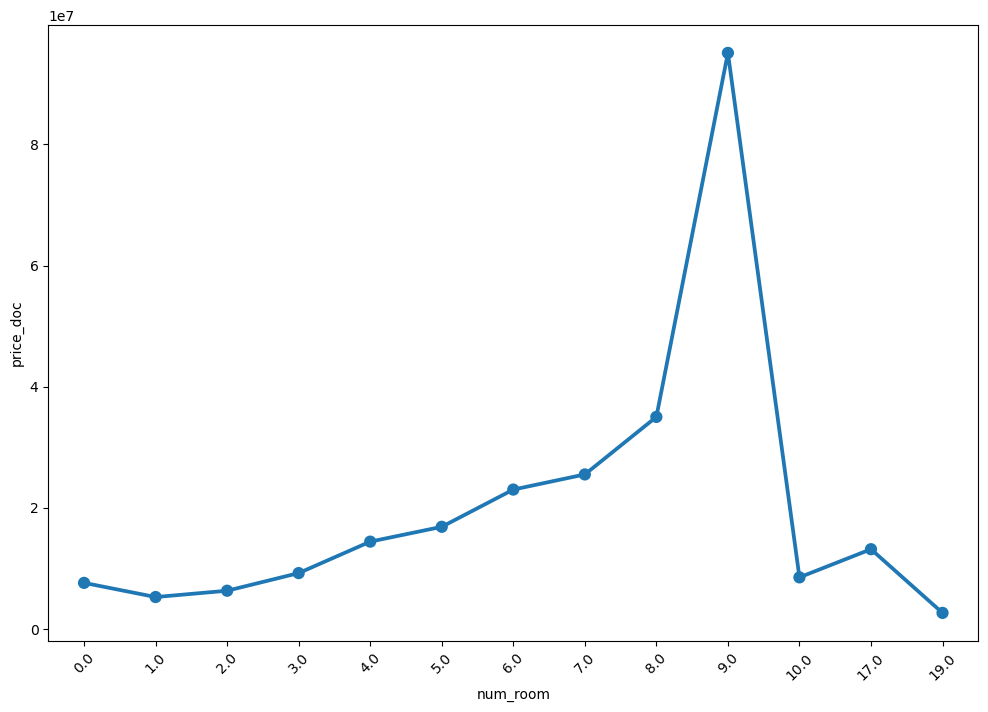

In [48]:
plt.figure(figsize=(12, 8))
plt.xticks(rotation=45)
df = x.groupby(by=['num_room'])['price_doc'].aggregate(np.median).reset_index()
sns.pointplot(x='num_room', y='price_doc', data=df)

In [49]:
# Можно видеть непонятные значения, отсутствие комнат, а таже аномальное значение цены 

In [50]:
x[x['num_room']==0]

,id,timestamp,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,mosque_count_2000,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,cpi,ppi,gdp_deflator,usdrub,eurrub,gdp_annual,gdp_annual_growth,rts,micex_rgbi_tr,micex_cbi_tr,deposits_value,grp,salary,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,labor_force,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,fin_res_per_cap,construction_value,average_life_exp,incidence_population,child_on_acc_pre_school,load_of_teachers_school_per_teacher,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,hospital_beds_available_per_cap,h

In [51]:
df = list(x[(x['num_room']>=0) & (x['life_sq']==0)].index)
x = x.drop(index=df)

In [52]:
df1 = list(x[x['num_room']==0].index)

In [53]:
x = x.drop(index = df1)

In [54]:
df2 = list(x[x['num_room']==9].index)

In [55]:
x = x.drop(index = df2)

In [56]:
# Выведем средний размер жилой комнаты

In [57]:
x['room_size'] = x['life_sq']/x['num_room']

In [58]:
# Посмотрим на категориальные признаки

In [59]:
num_features = x.dtypes[x.dtypes != 'object'].index
cat_features = x.dtypes[x.dtypes == 'object'].index

print('Количественные признаки:', len(num_features))
print('Категориальные признаки:', len(cat_features))

Количественные признаки: 215
Категориальные признаки: 19


In [60]:
for cat in cat_features:
    print(cat, x[cat].nunique())

timestamp 1161
product_type 2
sub_area 146
culture_objects_top_25 2
thermal_power_plant_raion 2
incineration_raion 2
oil_chemistry_raion 2
radiation_raion 2
railroad_terminal_raion 2
big_market_raion 2
nuclear_reactor_raion 2
detention_facility_raion 2
water_1line 2
big_road1_1line 2
railroad_1line 2
ecology 5
child_on_acc_pre_school 3
modern_education_share 3
old_education_build_share 3


In [61]:
for feat in cat_features:
    print(feat)
    if feat not in ['sub_area']:
        print(x[feat].unique())

timestamp
['2011-08-20' '2011-08-23' '2011-08-27' ... '2015-06-27' '2015-06-29'
 '2015-06-30']
product_type
['Investment' 'OwnerOccupier']
sub_area
culture_objects_top_25
['no' 'yes']
thermal_power_plant_raion
['no' 'yes']
incineration_raion
['no' 'yes']
oil_chemistry_raion
['no' 'yes']
radiation_raion
['no' 'yes']
railroad_terminal_raion
['no' 'yes']
big_market_raion
['no' 'yes']
nuclear_reactor_raion
['no' 'yes']
detention_facility_raion
['no' 'yes']
water_1line
['no' 'yes']
big_road1_1line
['no' 'yes']
railroad_1line
['no' 'yes']
ecology
['good' 'excellent' 'poor' 'satisfactory' 'no data']
child_on_acc_pre_school
['16,765' '7,311' '3,013']
modern_education_share
['93,08' '90,92' '95,4918']
old_education_build_share
['25,47' '23,14' '8,2517']


In [62]:
# Большинство из них принимают занчения yes\no
# Для удоства последующих расчетов, перекодируем их в 0/1 с помощью лямбда-функци

In [63]:
x['culture_objects_top_25'] = x['culture_objects_top_25'].apply(lambda x: 1 if x == 'yes' else 0)
x['thermal_power_plant_raion'] = x['thermal_power_plant_raion'].apply(lambda x: 1 if x == 'yes' else 0)
x['incineration_raion'] = x['incineration_raion'].apply(lambda x: 1 if x == 'yes' else 0)
x['oil_chemistry_raion'] = x['oil_chemistry_raion'].apply(lambda x: 1 if x == 'yes' else 0)
x['radiation_raion'] = x['radiation_raion'].apply(lambda x: 1 if x == 'yes' else 0)
x['railroad_terminal_raion'] = x['railroad_terminal_raion'].apply(lambda x: 1 if x == 'yes' else 0)
x['big_market_raion'] = x['big_market_raion'].apply(lambda x: 1 if x == 'yes' else 0)
x['nuclear_reactor_raion'] = x['nuclear_reactor_raion'].apply(lambda x: 1 if x == 'yes' else 0)
x['detention_facility_raion'] = x['detention_facility_raion'].apply(lambda x: 1 if x == 'yes' else 0)
x['water_1linen'] = x['water_1line'].apply(lambda x: 1 if x == 'yes' else 0)
x['big_road1_1line'] = x['big_road1_1line'].apply(lambda x: 1 if x == 'yes' else 0)
x['railroad_1line'] = x['railroad_1line'].apply(lambda x: 1 if x == 'yes' else 0)
x['water_1line'] = x['water_1line'].apply(lambda x: 1 if x == 'yes' else 0)
x['product_type'] = x['product_type'].apply(lambda x: 1 if x == 'Investment' else 0)

In [64]:
# Перекодируем значения столбцов в числовые, заменив разделитель на "."

In [65]:
x['child_on_acc_pre_school'] = x['child_on_acc_pre_school'].str.replace(',', '.').astype(float)
x['modern_education_share'] = x['modern_education_share'].str.replace(',', '.').astype(float)
x['old_education_build_share'] = x['old_education_build_share'].str.replace(',', '.').astype(float)

In [66]:
for feat in cat_features:
    print(feat)
    if feat not in ['sub_area']:
        print(x[feat].unique())

timestamp
['2011-08-20' '2011-08-23' '2011-08-27' ... '2015-06-27' '2015-06-29'
 '2015-06-30']
product_type
[1 0]
sub_area
culture_objects_top_25
[0 1]
thermal_power_plant_raion
[0 1]
incineration_raion
[0 1]
oil_chemistry_raion
[0 1]
radiation_raion
[0 1]
railroad_terminal_raion
[0 1]
big_market_raion
[0 1]
nuclear_reactor_raion
[0 1]
detention_facility_raion
[0 1]
water_1line
[0 1]
big_road1_1line
[0 1]
railroad_1line
[0 1]
ecology
['good' 'excellent' 'poor' 'satisfactory' 'no data']
child_on_acc_pre_school
[16.765  7.311  3.013]
modern_education_share
[93.08   90.92   95.4918]
old_education_build_share
[25.47   23.14    8.2517]


In [67]:
num_features = x.dtypes[x.dtypes != 'object'].index
cat_features = x.dtypes[x.dtypes == 'object'].index

print('Количественные признаки:', len(num_features))
print('Категориальные признаки:', len(cat_features))

Количественные признаки: 232
Категориальные признаки: 3


In [68]:
cat_features

Index(['timestamp', 'sub_area', 'ecology'], dtype='object')

In [69]:
# Перекодируем значения столбцов в числовые, преобразовав столбец в категорию,
# а затем использовать это значение категории для кодирования метки

In [70]:
x['ecology'].value_counts()

poor            8013
no data         7620
good            7162
excellent       3934
satisfactory    3682
Name: ecology, dtype: int64

In [71]:
x['ecology'] = x['ecology'].astype('category')
x.dtypes

id                                          int64
timestamp                                  object
full_sq                                     int64
life_sq                                   float64
floor                                     float64
num_room                                  float64
state                                     float64
product_type                                int64
sub_area                                   object
area_m                                    float64
raion_popul                                 int64
children_preschool                          int64
preschool_education_centers_raion           int64
children_school                             int64
school_education_centers_raion              int64
school_education_centers_top_20_raion       int64
hospital_beds_raion                       float64
healthcare_centers_raion                    int64
university_top_20_raion                     int64
sport_objects_raion                         int64


In [72]:
x['ecology'] = x['ecology'].cat.codes
x.head()

,id,timestamp,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,mosque_count_2000,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,cpi,ppi,gdp_deflator,usdrub,eurrub,gdp_annual,gdp_annual_growth,rts,micex_rgbi_tr,micex_cbi_tr,deposits_value,grp,salary,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,labor_force,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,fin_res_per_cap,construction_value,average_life_exp,incidence_population,child_on_acc_pre_school,load_of_teachers_school_per_teacher,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,hospital_beds_available_per_cap,h

In [73]:
x['sub_area'].value_counts()

Poselenie Sosenskoe               1766
Nekrasovka                        1603
Poselenie Vnukovskoe              1367
Poselenie Moskovskij               922
Poselenie Voskresenskoe            709
Mitino                             676
Tverskoe                           676
Krjukovo                           517
Mar'ino                            508
Poselenie Filimonkovskoe           496
Juzhnoe Butovo                     451
Poselenie Shherbinka               433
Solncevo                           421
Zapadnoe Degunino                  409
Poselenie Desjonovskoe             361
Otradnoe                           353
Nagatinskij Zaton                  326
Nagornoe                           305
Bogorodskoe                        305
Strogino                           301
Izmajlovo                          299
Tekstil'shhiki                     297
Ljublino                           297
Gol'janovo                         295
Severnoe Tushino                   282
Chertanovo Juzhnoe       

In [74]:
x['sub_area'] = x['sub_area'].astype('category')
x.dtypes

id                                          int64
timestamp                                  object
full_sq                                     int64
life_sq                                   float64
floor                                     float64
num_room                                  float64
state                                     float64
product_type                                int64
sub_area                                 category
area_m                                    float64
raion_popul                                 int64
children_preschool                          int64
preschool_education_centers_raion           int64
children_school                             int64
school_education_centers_raion              int64
school_education_centers_top_20_raion       int64
hospital_beds_raion                       float64
healthcare_centers_raion                    int64
university_top_20_raion                     int64
sport_objects_raion                         int64


In [75]:
x['sub_area'] = x['sub_area'].cat.codes
x.head()

,id,timestamp,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,mosque_count_2000,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,cpi,ppi,gdp_deflator,usdrub,eurrub,gdp_annual,gdp_annual_growth,rts,micex_rgbi_tr,micex_cbi_tr,deposits_value,grp,salary,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,labor_force,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,fin_res_per_cap,construction_value,average_life_exp,incidence_population,child_on_acc_pre_school,load_of_teachers_school_per_teacher,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,hospital_beds_available_per_cap,h

In [76]:
#Разделим выборку на тренировочную и тестовую

In [77]:
y = x['price_doc_log']
X = x.drop(['price_doc_log'], axis=1)


In [78]:
y.shape

(30411,)

In [79]:
X.shape

(30411, 234)

In [80]:
X = X.drop('timestamp', axis=1)
X = X.drop('price_doc', axis=1)
X = X.drop('id', axis=1)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()

In [82]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [83]:
# обучение

In [84]:
#LinearRegression

In [85]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lin_predictions_log = lr_model.predict(X_test_scaled)
lin_predictions = np.exp(lin_predictions_log)

In [86]:
np.any(np.isfinite(lin_predictions))

True

In [87]:
from sklearn.metrics import mean_squared_log_error
print('RMSLE linear regression:', np.sqrt(mean_squared_log_error(np.exp(y_test), lin_predictions)))

RMSLE linear regression: 0.48415833951041676


In [88]:
#DecisionTreeRegressor

In [89]:
tree = DecisionTreeRegressor(random_state = 42, max_depth=7, min_samples_split=20)  
tree.fit(X_train_scaled, y_train)

tree_predictions_log = tree.predict(X_test_scaled)
tree_predictions = np.exp(tree_predictions_log)

In [90]:
print('RMSLE Decision Tree:', np.sqrt(mean_squared_log_error(np.exp(y_test), tree_predictions)))

RMSLE Decision Tree: 0.48151282413793406


In [91]:
#XGBoost

In [92]:
xg_train = xgboost.DMatrix(X_train_scaled, y_train)
xg_test = xgboost.DMatrix(X_test_scaled, y_test)

In [93]:
xgb = xgboost.XGBRegressor(random_state=42)

In [94]:
xgbg = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1, importance_type='gain', interaction_constraints='', learning_rate=0.03, max_delta_step=0, max_depth=5, min_child_weight=4, monotone_constraints='()', n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.7, tree_method='exact', validate_parameters=1, verbosity=None)

In [95]:
xgbg.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy=None, importance_type='gain',
             interaction_constraints='', learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=5, max_leaves=None, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor=None, random_state=42, ...)

In [96]:
xgb_predictions_log = xgbg.predict(X_test_scaled)

In [97]:
xgb_predictions = np.exp(xgb_predictions_log)

In [98]:
print('RMSLE XGB:', np.sqrt(mean_squared_log_error(np.exp(y_test), xgb_predictions)))

RMSLE XGB: 0.44766241427430986


In [99]:
#Посмотрим на анализ важности признаков

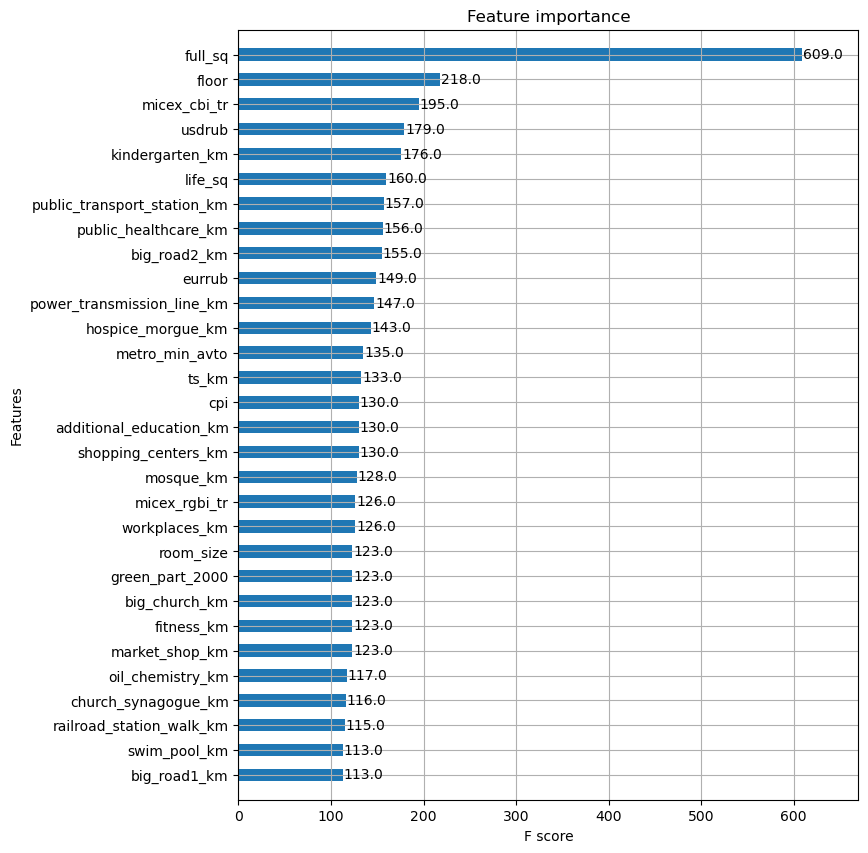

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
_= xgboost.plot_importance(xgbg, max_num_features=30, height=0.5, ax=ax)